# Part 1: Task Description

Train a RL agent for stock trading. The task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.


Let's specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Like a human trader analyzes various information, here our agent passively observes many features and learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data of the single stock that I will use is obtained from Yahoo Finance API. The data contains Open-High-Low-Close prices and volume.


# Part 2: Imports

In [ ]:
## install finrl library
#!pip install wrds
#!pip install swig
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from datetime import timedelta
from collections import deque

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from pprint import pprint
import sys
sys.path.append("../FinRL")

import itertools

In [ ]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    import torch
    torch.manual_seed(seed)

set_seed(42)

# Part 3: Download Data

Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
# Define dates
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

# Download data
downloader = YahooDownloader(start_date=TRAIN_START_DATE,
                             end_date=TEST_END_DATE,
                             ticker_list=DOW_30_TICKER)
df = downloader.fetch_data()
print(df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (93702, 8)
Price        date      close       high        low       open     volume  \
0      2010-01-04   6.418385   6.433080   6.369499   6.400990  493729600   
1      2010-01-04  39.311695  39.413855  38.521647  38.569322    5277400   
2      2010-01-04  32.555466  32.698672  32.133805  32.467954    6894300   
3      2010-01-04  43.777542  43.941181  42.702194  43.419094    6186700   
4      2010-01-04  39.290581  39.720059  38.592677  38.686628    7325600   

Price   tic  day  
0      AAPL    0  
1      AMGN    0  
2       AXP    0  
3        BA    0  
4       CAT    0  


In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.418385,6.433080,6.369499,6.400990,493729600,AAPL,0
1,2010-01-04,39.311695,39.413855,38.521647,38.569322,5277400,AMGN,0
2,2010-01-04,32.555466,32.698672,32.133805,32.467954,6894300,AXP,0
3,2010-01-04,43.777542,43.941181,42.702194,43.419094,6186700,BA,0
4,2010-01-04,39.290581,39.720059,38.592677,38.686628,7325600,CAT,0


In [ ]:
df_aapl = df[df['tic'] == 'AAPL']

In [ ]:
df_aapl.set_index('date', inplace=True)

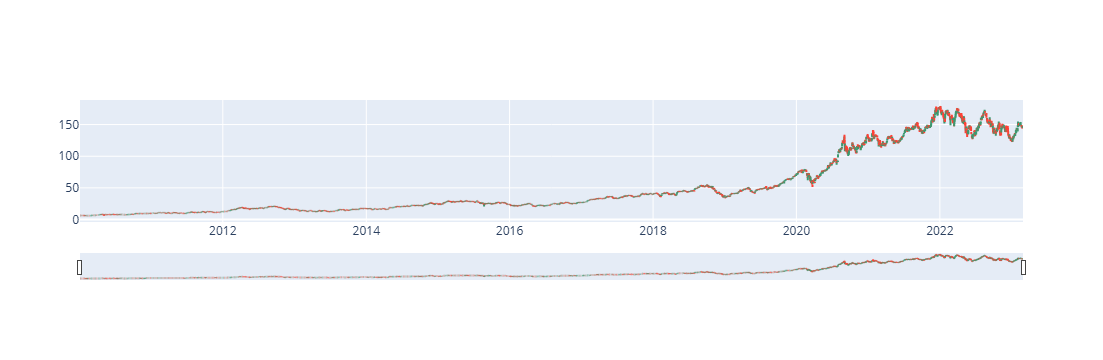

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
    data=go.Ohlc(
        x=df_aapl.index,
        open=df_aapl["open"],
        high=df_aapl["high"],
        low=df_aapl["low"],
        close=df_aapl["close"],
    )
)
fig.show()

In [ ]:
df_aapl.loc[:, 'ma20'] = df.close.rolling(20).mean()
df_aapl.loc[:, 'ma200'] = df.close.rolling(200).mean()

<Axes: xlabel='date'>

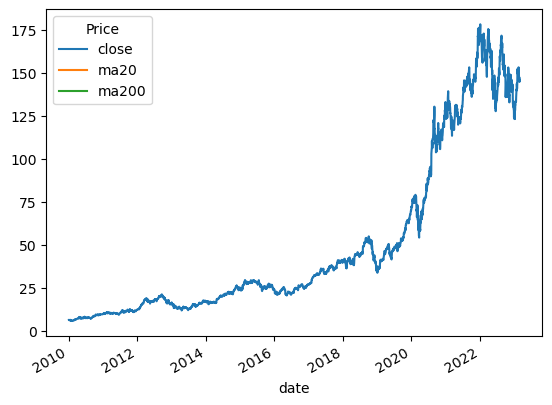

In [ ]:
df_aapl[["close", "ma20", "ma200"]].plot()

In [ ]:
import talib
df_aapl.loc[:, "rsi"] = talib.RSI(df_aapl.close, 14)

<Axes: >

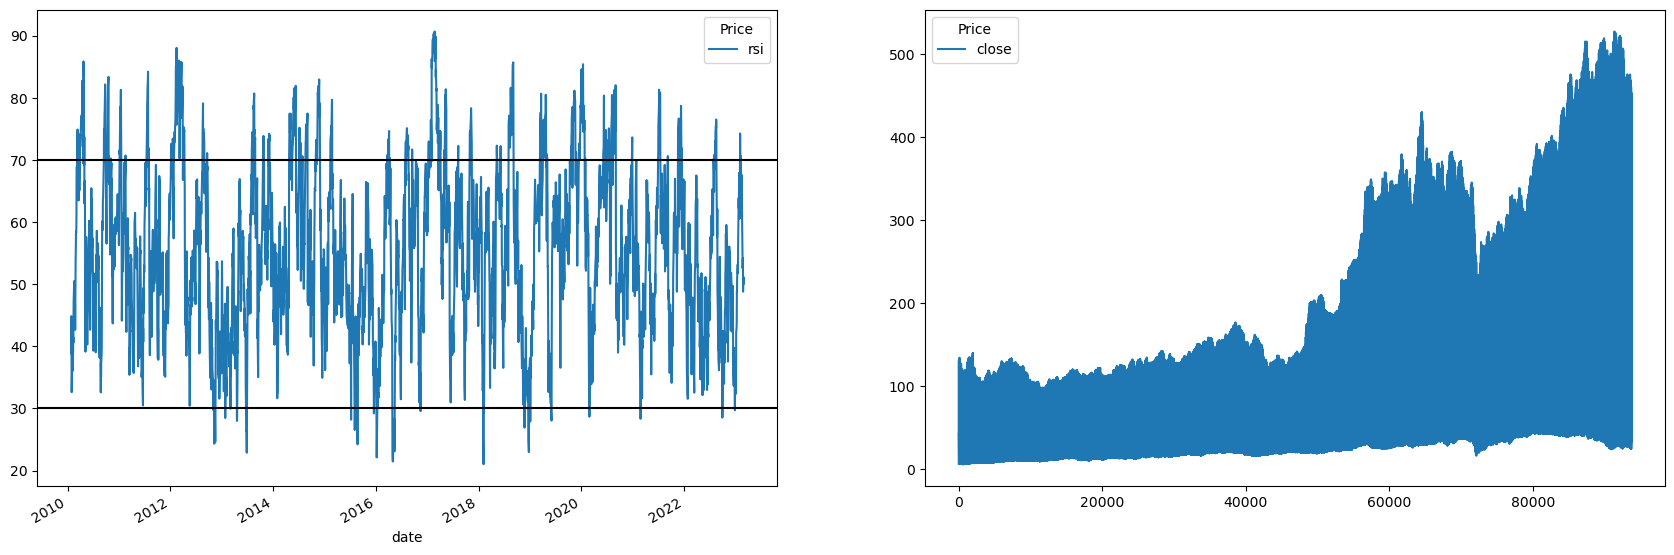

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))


ax0 = df_aapl[["rsi"]].plot(ax=ax[0])
ax0.axhline(30, color="black")
ax0.axhline(70, color="black")

df[["close"]].plot(ax=ax[1])

# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/).
- Goal: create features that will garantee that Markov property is achieved

## 4.1 Import the financial data

In [ ]:
path_wrds = 'dow_30_fundamental_wrds.csv'

fund = pd.read_csv(path_wrds, low_memory=False, index_col = 0)

In [ ]:
fund.shape

(2456, 647)

In [ ]:
df.shape

(93702, 8)

In [ ]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,...,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,...,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,...,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,...,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,...,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


## 4.2 Specify items needed to calculate financial ratios

In [ ]:
# List items that are used to calculate financial ratios

items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities
]

# Omit items that will not be used
fund_data = fund[items]

In [ ]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'op_inc_q', # Quarterly operating income
    'revtq':'rev_q', # Quartely revenue
    'niq':'net_inc_q', # Quartely net income
    'atq':'tot_assets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'com_eq', # Common Equity
    'cshoq':'sh_outstanding', # Common Shares Outstanding
    'dvpspq':'div_per_sh', # Dividends per share
    'actq':'cur_assets', # Current assets
    'lctq':'cur_liabilities', # Current liabilities
    'cheq':'cash_eq', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cogs_q', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_debt', # Long term debt
    'dlcq':'short_debt', # Debt in current liabilites
    'ltq':'tot_liabilities' # Liabilities
})

In [ ]:
# Check the data
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,19990630,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,19990930,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,19991231,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,20000331,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,20000630,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


In [ ]:
fund_data['date'] = pd.to_datetime(fund_data['date'],format='%Y%m%d')
fund_data.head()


,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-30,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,1999-09-30,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,1999-12-31,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,2000-03-31,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,2000-06-30,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


In [ ]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'day'], dtype='object', name='Price')

## 4.3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [ ]:
def calculate_financial_ratios(fund_data):
    """
    Colculate financial ratios using fundamental ratios only
    """
    fund_data = fund_data.sort_values(['tic', 'date'])

    fund_data['BPS'] = fund_data['com_eq'] / fund_data['sh_outstanding'] # Earnings Per Share
    fund_data['EPS'] = fund_data['eps_incl_ex'] # Book Per Share
    fund_data['DPS'] = fund_data['div_per_sh'] # Dividend Per Share

    # LTM colculations
    def ltm_sum(group, col):
        return group[col].rolling(window=4, min_periods=1).sum()

    def ltm_ratio(group, num_col, denom_col):
        numerator = group[num_col].rolling(window=4, min_periods=1).sum()
        denominator = group[denom_col].rolling(window=4, min_periods=1).sum()
        return numerator / denominator


    fund_data = fund_data.groupby('tic').apply(
        lambda x: x.assign(
            OPM=ltm_ratio(x, 'op_inc_q', 'rev_q'), # Operating Margin
            NPM=ltm_ratio(x, 'net_inc_q', 'rev_q'), # Net Profit Margin
            ROA=ltm_sum(x, 'net_inc_q') / x['tot_assets'], # Return On Assets
            ROE=ltm_sum(x, 'net_inc_q') / x['sh_equity'], # Return On Enquity
            inv_turnover=ltm_sum(x, 'cogs_q') / x['inventories'], # Inventory turnover ratio
            acc_rec_turnover=ltm_sum(x, 'rev_q') / x['receivables'], # Receivables turnover ratio
            acc_pay_turnover=ltm_sum(x, 'cogs_q') / x['payables'] # Payable turnover ratio
        )
    ).reset_index(drop=True)

    fund_data['cur_ratio'] = fund_data['cur_assets'] / fund_data['cur_liabilities']
    fund_data['quick_ratio'] = (fund_data['cash_eq'] + fund_data['receivables']) / fund_data['cur_liabilities']
    fund_data['cash_ratio'] = fund_data['cash_eq'] / fund_data['cur_liabilities']
    fund_data['debt_ratio'] = fund_data['tot_liabilities'] / fund_data['tot_assets']
    fund_data['debt_to_equity'] = fund_data['tot_liabilities'] / fund_data['sh_equity']

    # Growth metrics
    fund_data['revenue_growth'] = fund_data.groupby('tic')['rev_q'].pct_change(4)
    fund_data['eps_growth'] = fund_data.groupby('tic')['EPS'].pct_change(4)

    return fund_data

def calculate_valuation_ratios(fund_data_with_prices):
    """
    Culculate valuation ratios AFTER merging with stock prices with time lag
    """
    # P/E Ratio (Price-to-Earnings)
    fund_data_with_prices['PE_ratio'] = fund_data_with_prices['close'] / fund_data_with_prices['EPS']

    # P/B Ratio (Price-to-Book)
    fund_data_with_prices['PB_ratio'] = fund_data_with_prices['close'] / fund_data_with_prices['BPS']

    # Dividend Yield
    fund_data_with_prices['dividend_yield'] = (fund_data_with_prices['DPS'] * 4) / fund_data_with_prices['close']

    # P/S Ratio (Price-to-Sales)
    fund_data_with_prices['market_cap'] = fund_data_with_prices['close'] * fund_data_with_prices['sh_outstanding']
    fund_data_with_prices['PS_ratio'] = fund_data_with_prices['market_cap'] / fund_data_with_prices['rev_q'].rolling(4).sum()

    # EV (Enterprise Value) = Market Cap + Total Debt - Cash
    if all(col in fund_data_with_prices.columns for col in ['market_cap', 'long_debt', 'short_debt', 'cash_eq']):
        fund_data_with_prices['enterprise_value'] = (
            fund_data_with_prices['market_cap'] +
            fund_data_with_prices['long_debt'] +
            fund_data_with_prices['short_debt'] -
            fund_data_with_prices['cash_eq']
        )
        # EV/EBITDA
        if 'op_inc_q' in fund_data_with_prices.columns:
            fund_data_with_prices['EV_EBITDA'] = (
                fund_data_with_prices['enterprise_value'] /
                fund_data_with_prices['op_inc_q'].rolling(4).sum()
            )

    # Process inf and values
    valuation_columns = ['PE_ratio', 'PB_ratio', 'dividend_yield', 'PS_ratio']

    for col in valuation_columns:
        if col in fund_data_with_prices.columns:
            # Replace inf with NaN
            fund_data_with_prices[col] = fund_data_with_prices[col].replace([np.inf, -np.inf], np.nan)
            # Adjust to reasonable values
            if col == 'PE_ratio':
                fund_data_with_prices[col] = fund_data_with_prices[col].clip(0, 100)  # P/E from 0 to 100
            elif col == 'PB_ratio':
                fund_data_with_prices[col] = fund_data_with_prices[col].clip(0, 10)   # P/B from 0 to 10
            elif col == 'PS_ratio':
                fund_data_with_prices[col] = fund_data_with_prices[col].clip(0, 20)   # P/S from 0 to 20
            elif col == 'dividend_yield':
                fund_data_with_prices[col] = fund_data_with_prices[col].clip(0, 0.2)  # Dividend Yield up to 20%

    return fund_data_with_prices

def merge_with_lag_and_calculate_valuations(fund_data, price_data, lag_days=45):
    # Add lag
    fund_data['date_available'] = fund_data['date'] + timedelta(days=lag_days)

    # To avoid conflict with 'date' in price_data
    fund_data = fund_data.drop(['date'], axis=1)
    print(price_data.shape)
    print(fund_data.shape)
    merged_data = pd.merge_asof(
        price_data.sort_values('date'),
        fund_data.sort_values('date_available'),
        left_on='date',
        right_on='date_available',
        by='tic',
        direction='backward'
    )

    merged_data = calculate_valuation_ratios(merged_data)
    # Forward fill
    merged_data = merged_data.sort_values(['tic', 'date'])

    tic_col = merged_data['tic']
    merged_data = merged_data.groupby('tic').ffill()

    merged_data['tic'] = tic_col
    return merged_data

# Pipeline
def create_final_dataset_correct(fund_data, dow_30_data):

    fund_with_ratios = calculate_financial_ratios(fund_data)

    final_data = merge_with_lag_and_calculate_valuations(fund_with_ratios, dow_30_data)

    return final_data


In [ ]:
fund_data.shape

(2456, 21)

In [ ]:
df.shape

(93702, 8)

In [ ]:
final_data = create_final_dataset_correct(fund_data, df)
final_data.shape

(93702, 8)
(2456, 38)


C:\Users\ivanp\AppData\Local\Temp\ipykernel_6900\147708415.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fund_data = fund_data.groupby('tic').apply(
C:\Users\ivanp\AppData\Local\Temp\ipykernel_6900\147708415.py:40: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fund_data['revenue_growth'] = fund_data.groupby('tic')['rev_q'].pct_change(4)
C:\Users\ivanp\AppData\Local\Temp\ipykernel_6900\147708415.py:41: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is depreca

(93702, 52)

## 4.4 Deal with NAs and infinite values
- Replace N/A and infinite values with zero.

In [ ]:
def analyze_missing_data(final_data):
    print("Analyze of NaNs in data:")
    print("=" * 50)

    key_columns = ['OPM', 'ROE', 'EPS', 'PE_ratio', 'PB_ratio', 'revenue_growth']

    missing_stats = {}
    for col in key_columns:
        if col in final_data.columns:
            missing_count = final_data[col].isna().sum()
            missing_pct = (missing_count / len(final_data)) * 100
            missing_stats[col] = (missing_count, missing_pct)
            print(f"{col}: {missing_count} NaNs ({missing_pct:.1f}%)")

    return missing_stats

missing_stats = analyze_missing_data(final_data)

Analyze of NaNs in data:
OPM: 13244 NaNs (14.1%)
ROE: 9933 NaNs (10.6%)
EPS: 9933 NaNs (10.6%)
PE_ratio: 9933 NaNs (10.6%)
PB_ratio: 9972 NaNs (10.6%)
revenue_growth: 13244 NaNs (14.1%)


In [ ]:
# Delete critical NaNs
critical_cols = ['close', 'date', 'tic', 'EPS']
data_clean = final_data.dropna(subset=critical_cols)

# Forward fill inside tics
data_clean = data_clean.sort_values(['tic', 'date'])
tic_col = data_clean['tic']
data_clean = data_clean.groupby('tic').ffill()
data_clean['tic'] = tic_col
# fill with median value
simple_fill_cols = ['OPM', 'ROE', 'PE_ratio', 'PB_ratio','revenue_growth']
for col in simple_fill_cols:
    if col in data_clean.columns:
        # fill median for tic
        data_clean[col] = data_clean.groupby('tic')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # fill median for market if NaN again
        data_clean[col] = data_clean[col].fillna(data_clean[col].median())

missing_stats = analyze_missing_data(data_clean)

Analyze of NaNs in data:
OPM: 0 NaNs (0.0%)
ROE: 0 NaNs (0.0%)
EPS: 0 NaNs (0.0%)
PE_ratio: 0 NaNs (0.0%)
PB_ratio: 0 NaNs (0.0%)
revenue_growth: 0 NaNs (0.0%)


In [ ]:
data_clean.shape

(83769, 52)

In [ ]:
df_cleaned = data_clean.ffill()
df_cleaned = df_cleaned.dropna()

In [ ]:
df_cleaned = df_cleaned.replace(np.inf,0)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83765 entries, 127 to 93701
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              83765 non-null  datetime64[ns]
 1   close             83765 non-null  float64       
 2   high              83765 non-null  float64       
 3   low               83765 non-null  float64       
 4   open              83765 non-null  float64       
 5   volume            83765 non-null  int64         
 6   day               83765 non-null  int32         
 7   op_inc_q          83765 non-null  float64       
 8   rev_q             83765 non-null  float64       
 9   net_inc_q         83765 non-null  float64       
 10  tot_assets        83765 non-null  float64       
 11  sh_equity         83765 non-null  float64       
 12  eps_incl_ex       83765 non-null  float64       
 13  com_eq            83765 non-null  float64       
 14  sh_outstanding    83765 n

In [ ]:
df_cleaned.to_csv("dow_wnds.csv")

# 4.5 GRU preprocessing

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83765 entries, 127 to 93701
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              83765 non-null  datetime64[ns]
 1   close             83765 non-null  float64       
 2   high              83765 non-null  float64       
 3   low               83765 non-null  float64       
 4   open              83765 non-null  float64       
 5   volume            83765 non-null  int64         
 6   day               83765 non-null  int64         
 7   op_inc_q          83765 non-null  float64       
 8   rev_q             83765 non-null  float64       
 9   net_inc_q         83765 non-null  float64       
 10  tot_assets        83765 non-null  float64       
 11  sh_equity         83765 non-null  float64       
 12  eps_incl_ex       83765 non-null  float64       
 13  com_eq            83765 non-null  float64       
 14  sh_outstanding    83765 n

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# Add Technical Indicators using FinRL's FeatureEngineer
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']  # Standard tech

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_turbulence=True,  # From papers, adds risk awareness
    user_defined_feature=False
)

processed = fe.preprocess_data(df_cleaned)

Successfully added technical indicators


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Successfully added turbulence index


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
processed['tic'].nunique()

24

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import time

# Enable all CUDA optimizations for H100
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# GRU for Multi-Step Forecasting - OPTIMIZED FOR H100 (FIXED)
class GRUForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=2, forecast_steps=5, dropout=0.1):
        super(GRUForecaster, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_steps = forecast_steps
        self.output_dim = output_dim

        # Optimized bidirectional GRU for H100
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Simplified attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim * forecast_steps)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim,
                         device=x.device, dtype=x.dtype)

        # GRU processing
        gru_out, _ = self.gru(x, h0)  # [batch, seq_len, hidden_dim*2]

        # Simple attention mechanism
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)  # [batch, seq_len, 1]
        context_vector = (attention_weights * gru_out).sum(dim=1)  # [batch, hidden_dim*2]

        # Generate forecasts
        forecasts = self.fc(context_vector)  # [batch, output_dim*forecast_steps]
        return forecasts.view(batch_size, self.forecast_steps, self.output_dim)


def add_gru_forecasts(df, lookback=60, forecast_steps=5, train_test_split=0.7, epochs=50, use_amp=False):
    """
    Add GRU-based forecasts to dataframe with proper indexing
    """
    from torch.amp import autocast, GradScaler  # Новый API

    # Сортируем данные для корректной индексации
    df = df.sort_values(['tic', 'date']).reset_index(drop=True)

    # Select features
    exclude_columns = ['date', 'date_available', 'tic']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [col for col in numeric_cols if col not in exclude_columns]

    tics = df['tic'].unique()
    all_forecasts = {}

    input_dim = len(features)
    hidden_dim = 128
    output_dim = 1

    print(f"Starting GRU forecasting for {len(tics)} assets...")
    print(f"Using {input_dim} features")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Optimal batch size
    if device.type == 'cuda':
        device_name = torch.cuda.get_device_name(0)
        if 'H100' in device_name or 'A100' in device_name:
            batch_size = 256
        else:
            batch_size = 128
    else:
        batch_size = 32

    print(f"Using batch size: {batch_size}")

    total_start_time = time.time()

    for idx, tic in enumerate(tics, 1):
        tic_start_time = time.time()
        print(f"\n{'='*60}")
        print(f"Processing {tic} ({idx}/{len(tics)})")
        print(f"{'='*60}")

        # Get data for this ticker (уже отсортировано)
        tic_mask = df['tic'] == tic
        tic_indices = df[tic_mask].index
        tic_df = df.loc[tic_mask].copy()

        # Check if enough data
        min_required = lookback + forecast_steps + 10
        if len(tic_df) < min_required:
            print(f"  Skipping {tic}: insufficient data ({len(tic_df)} < {min_required})")
            continue

        # Prepare data
        data = tic_df[features].values.astype(np.float32)
        prices = tic_df['close'].values.astype(np.float32)

        # Normalize features
        split_idx = int(len(data) * train_test_split)
        normalized_data = np.zeros_like(data, dtype=np.float32)

        for i in range(input_dim):
            scaler = MinMaxScaler()
            train_data = data[:split_idx, i].reshape(-1, 1)
            if len(train_data) > 0:
                scaler.fit(train_data)
                normalized_data[:, i] = scaler.transform(data[:, i].reshape(-1, 1)).flatten()

        # Create sequences
        seq_len = len(normalized_data) - lookback - forecast_steps
        if seq_len <= 10:  # Минимум 10 последовательностей
            print(f"  Skipping {tic}: not enough sequences ({seq_len})")
            continue

        X = np.zeros((seq_len, lookback, input_dim), dtype=np.float32)
        y = np.zeros((seq_len, forecast_steps), dtype=np.float32)

        for i in range(seq_len):
            X[i] = normalized_data[i:i + lookback]
            base_price = prices[i + lookback - 1]
            future_prices = prices[i + lookback:i + lookback + forecast_steps]
            y[i] = (future_prices - base_price) / base_price

        # Debug info
        print(f"  Created {len(X)} sequences")
        print(f"  X shape: {X.shape}, y shape: {y.shape}")

        # Split data
        train_size = int(len(X) * train_test_split)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"  Skipping {tic}: no training/test data")
            continue

        print(f"  Training samples: {len(X_train)}, Test samples: {len(X_test)}")

        # Convert to tensors
        X_train_tensor = torch.from_numpy(X_train).to(device)
        y_train_tensor = torch.from_numpy(y_train).to(device)
        X_test_tensor = torch.from_numpy(X_test).to(device)
        y_test_tensor = torch.from_numpy(y_test).to(device)

        # Create model
        model = GRUForecaster(
            input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=1,
            forecast_steps=forecast_steps,
            dropout=0.2
        ).to(device)

        # Training
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        patience_counter = 0
        patience = 10
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0

            # Mini-batch training
            indices = torch.randperm(len(X_train_tensor))
            for i in range(0, len(X_train_tensor), batch_size):
                batch_idx = indices[i:i + batch_size]
                if len(batch_idx) == 0:
                    continue

                batch_X = X_train_tensor[batch_idx]
                batch_y = y_train_tensor[batch_idx]

                optimizer.zero_grad()
                predictions = model(batch_X).squeeze(-1)
                loss = criterion(predictions, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()

            # Validation
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_test_tensor).squeeze(-1)
                val_loss = criterion(val_predictions, y_test_tensor).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1

            if (epoch + 1) % 10 == 0:
                print(f"    Epoch {epoch+1}: Train Loss: {epoch_loss/(len(X_train_tensor)//batch_size+1):.6f}, "
                      f"Val Loss: {val_loss:.6f}")

            if patience_counter >= patience:
                print(f"    Early stopping at epoch {epoch+1}")
                break

        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        model.eval()

        # Generate forecasts for all sequences
        all_predictions = []
        with torch.no_grad():
            for i in range(0, len(X), batch_size * 2):
                end_idx = min(i + batch_size * 2, len(X))
                batch_X = torch.from_numpy(X[i:end_idx]).to(device)
                batch_pred = model(batch_X).squeeze(-1).cpu().numpy()
                all_predictions.append(batch_pred)

        if all_predictions:
            all_predictions = np.vstack(all_predictions)
            print(f"  Generated {len(all_predictions)} predictions")

            # КРИТИЧЕСКОЕ ИСПРАВЛЕНИЕ: Правильное сопоставление индексов
            # Создаем массив прогнозов с правильной индексацией
            predictions_array = np.full((len(tic_df), forecast_steps), np.nan, dtype=np.float32)

            # Заполняем прогнозы начиная с индекса lookback
            # each prediction corresponds to a starting point in the sequence
            for i in range(len(all_predictions)):
                # Индекс в исходном DataFrame для этого прогноза
                df_idx = i + lookback
                if df_idx < len(predictions_array):
                    predictions_array[df_idx] = all_predictions[i]

            all_forecasts[tic] = predictions_array
            print(f"  Predictions array shape: {predictions_array.shape}")
            print(f"  Non-NaN values: {np.sum(~np.isnan(predictions_array))}")

    # Save forecasts globally
    global all_forecasts_global
    all_forecasts_global = all_forecasts.copy()

    # КРИТИЧЕСКОЕ ИСПРАВЛЕНИЕ: Правильное заполнение DataFrame
    forecast_cols = [f'forecast_{i}' for i in range(1, forecast_steps + 1)]

    for col in forecast_cols:
        if col not in df.columns:
            df[col] = np.nan

    for tic, forecasts in all_forecasts.items():
        tic_mask = df['tic'] == tic
        tic_indices = df[tic_mask].index

        # Проверяем соответствие размеров
        if len(tic_indices) != len(forecasts):
            print(f"  Warning: Size mismatch for {tic}: "
                  f"DataFrame rows={len(tic_indices)}, Forecast rows={len(forecasts)}")
            continue

        # Заполняем столбцы прогнозов
        for step in range(forecast_steps):
            col_name = f'forecast_{step + 1}'

            # Получаем прогнозы для этого шага
            step_forecasts = forecasts[:, step]

            # Рассчитываем цены на основе прогнозов доходности
            # Берем цену закрытия предыдущего дня как базовую
            base_prices = df.loc[tic_mask, 'close'].values.copy()

            # Сдвигаем base_prices на 1 день назад для всех кроме первого
            shifted_prices = np.roll(base_prices, 1)
            shifted_prices[0] = base_prices[0]  # Первый день использует свою же цену

            # Рассчитываем прогнозируемые цены
            predicted_prices = shifted_prices * (1 + step_forecasts)

            # Заменяем NaN в прогнозах на NaN в ценах
            predicted_prices[np.isnan(step_forecasts)] = np.nan

            # Записываем в DataFrame
            df.loc[tic_mask, col_name] = predicted_prices

    # Forward fill для пропусков
    for col in forecast_cols:
        for tic in df['tic'].unique():
            mask = df['tic'] == tic
            df.loc[mask, col] = df.loc[mask, col].ffill()

    total_time = time.time() - total_start_time
    print(f"\n{'='*60}")
    print(f"GRU forecasting completed in {total_time:.2f}s")
    print(f"Processed {len(all_forecasts)} tickers")

    # Debug info
    for col in ['forecast_1', 'forecast_3', 'forecast_5']:
        if col in df.columns:
            non_null = df[col].notna().sum()
            null = df[col].isna().sum()
            print(f"{col}: {non_null} non-null, {null} null")

    return df

# Setup GPU optimizations
def setup_gpu_optimizations():
    """Configure PyTorch for optimal GPU performance"""
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        print(f"GPU: {device_name}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

        # New API for TF32 (PyTorch 2.0+)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Clear cache
        torch.cuda.empty_cache()

        return True
    return False


# Process the data with GRU forecasts
print("Adding GRU forecasts to processed data...")

# Setup GPU optimizations
setup_gpu_optimizations()

# Process your data
processed = add_gru_forecasts(
    processed,
    lookback=60,
    forecast_steps=5,
    train_test_split=0.7,
    epochs=50,
    use_amp=False  # Disabled due to cuDNN issues
)

# Show results
if 'forecast_1' in processed.columns:
    print(f"\nForecast columns added successfully!")
    print(f"\nSample data with forecasts:")
    sample_cols = ['date', 'tic', 'close'] + [f'forecast_{i}' for i in [1, 3, 5]]
    print(processed[sample_cols].head(10))

    # Statistics
    for col in ['forecast_1', 'forecast_3', 'forecast_5']:
        if col in processed.columns:
            non_null = processed[col].notna().sum()
            print(f"{col}: {non_null} non-null values")
else:
    print("\nWarning: Forecast columns were not added successfully.")

Adding GRU forecasts to processed data...
GPU: NVIDIA A100-SXM4-80GB
CUDA Version: 12.6
GPU Memory: 85.2 GB
Starting GRU forecasting for 24 assets...
Using 54 features
Using device: cuda
Using batch size: 256

Processing AXP (1/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000671, Val Loss: 0.001952
    Epoch 20: Train Loss: 0.000625, Val Loss: 0.001888
    Epoch 30: Train Loss: 0.000620, Val Loss: 0.001882
    Epoch 40: Train Loss: 0.000592, Val Loss: 0.001884
    Early stopping at epoch 41
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing BA (2/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000778, Val Loss: 0.011712
    Early stopping at epoch 12
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing CAT (3/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000950, Val Loss: 0.001369
    Early stopping at epoch 12
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing CSCO (4/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000786, Val Loss: 0.001831
    Early stopping at epoch 12
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing CVX (5/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000571, Val Loss: 0.001741
    Epoch 20: Train Loss: 0.000554, Val Loss: 0.001799
    Early stopping at epoch 20
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing DIS (6/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000510, Val Loss: 0.002404
    Early stopping at epoch 14
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing GS (7/24)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974
    Epoch 10: Train Loss: 0.000815, Val Loss: 0.001519
    Epoch 20: Train Loss: 0.000780, Val Loss: 0.001493
    Early stopping at epoch 23
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing HD (8/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000505, Val Loss: 0.001377
    Epoch 20: Train Loss: 0.000483, Val Loss: 0.001408
    Early stopping at epoch 25
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing IBM (9/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000548, Val Loss: 0.001021
    Early stopping at epoch 13
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing INTC (10/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000703, Val Loss: 0.001581
    Early stopping at epoch 13
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing JNJ (11/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000325, Val Loss: 0.000501
    Epoch 20: Train Loss: 0.000300, Val Loss: 0.000473
    Epoch 30: Train Loss: 0.000276, Val Loss: 0.000469
    Early stopping at epoch 34
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing JPM (12/24)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974
    Epoch 10: Train Loss: 0.000749, Val Loss: 0.001328
    Epoch 20: Train Loss: 0.000713, Val Loss: 0.001259
    Epoch 30: Train Loss: 0.000684, Val Loss: 0.001271
    Epoch 40: Train Loss: 0.000682, Val Loss: 0.001280
    Early stopping at epoch 47
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing KO (13/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000260, Val Loss: 0.000605
    Epoch 20: Train Loss: 0.000249, Val Loss: 0.000604
    Early stopping at epoch 26
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing MCD (14/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000308, Val Loss: 0.000827
    Epoch 20: Train Loss: 0.000286, Val Loss: 0.000760
    Early stopping at epoch 21
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing MMM (15/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000446, Val Loss: 0.000941
    Early stopping at epoch 16
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing MRK (16/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000472, Val Loss: 0.000741
    Epoch 20: Train Loss: 0.000434, Val Loss: 0.000701
    Epoch 30: Train Loss: 0.000427, Val Loss: 0.000684
    Epoch 40: Train Loss: 0.000419, Val Loss: 0.000671
    Epoch 50: Train Loss: 0.000413, Val Loss: 0.000699
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing MSFT (17/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000646, Val Loss: 0.000978
    Epoch 20: Train Loss: 0.000611, Val Loss: 0.000973
    Early stopping at epoch 24
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing NKE (18/24)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974
    Epoch 10: Train Loss: 0.000609, Val Loss: 0.001659
    Epoch 20: Train Loss: 0.000586, Val Loss: 0.001653
    Epoch 30: Train Loss: 0.000578, Val Loss: 0.001605
    Early stopping at epoch 38
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing PG (19/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000287, Val Loss: 0.000571
    Epoch 20: Train Loss: 0.000257, Val Loss: 0.000525
    Epoch 30: Train Loss: 0.000253, Val Loss: 0.000523
    Early stopping at epoch 34
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing TRV (20/24)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974
    Epoch 10: Train Loss: 0.000380, Val Loss: 0.001470
    Epoch 20: Train Loss: 0.000351, Val Loss: 0.001270
    Epoch 30: Train Loss: 0.000341, Val Loss: 0.001306
    Early stopping at epoch 39
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing UNH (21/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000644, Val Loss: 0.001108
    Epoch 20: Train Loss: 0.000614, Val Loss: 0.001054
    Epoch 30: Train Loss: 0.000605, Val Loss: 0.001069
    Early stopping at epoch 35
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing V (22/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000609, Val Loss: 0.001002
    Epoch 20: Train Loss: 0.000594, Val Loss: 0.000944
    Epoch 30: Train Loss: 0.000586, Val Loss: 0.000962
    Early stopping at epoch 30
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing VZ (23/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000380, Val Loss: 0.000507
    Early stopping at epoch 15
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230

Processing WMT (24/24)
  Created 3246 sequences
  X shape: (3246, 60, 54), y shape: (3246, 5)
  Training samples: 2272, Test samples: 974


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    Epoch 10: Train Loss: 0.000394, Val Loss: 0.001242
    Early stopping at epoch 13
  Generated 3246 predictions
  Predictions array shape: (3311, 5)
  Non-NaN values: 16230


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


GRU forecasting completed in 25.05s
Processed 24 tickers
forecast_1: 78024 non-null, 1440 null
forecast_3: 78024 non-null, 1440 null
forecast_5: 78024 non-null, 1440 null

Forecast columns added successfully!

Sample data with forecasts:
        date  tic      close  forecast_1  forecast_3  forecast_5
0 2010-01-04  AXP  32.555485         NaN         NaN         NaN
1 2010-01-05  AXP  32.483871         NaN         NaN         NaN
2 2010-01-06  AXP  33.008957         NaN         NaN         NaN
3 2010-01-07  AXP  33.544331         NaN         NaN         NaN
4 2010-01-08  AXP  33.520351         NaN         NaN         NaN
5 2010-01-11  AXP  33.136818         NaN         NaN         NaN
6 2010-01-12  AXP  33.576290         NaN         NaN         NaN
7 2010-01-13  AXP  33.680153         NaN         NaN         NaN
8 2010-01-14  AXP  34.103661         NaN         NaN         NaN
9 2010-01-15  AXP  33.871941         NaN         NaN         NaN
forecast_1: 78024 non-null values
forecast_3: 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79464 entries, 0 to 79463
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              79464 non-null  datetime64[ns]
 1   close             79464 non-null  float64       
 2   high              79464 non-null  float64       
 3   low               79464 non-null  float64       
 4   open              79464 non-null  float64       
 5   volume            79464 non-null  int64         
 6   day               79464 non-null  int64         
 7   op_inc_q          79464 non-null  float64       
 8   rev_q             79464 non-null  float64       
 9   net_inc_q         79464 non-null  float64       
 10  tot_assets        79464 non-null  float64       
 11  sh_equity         79464 non-null  float64       
 12  eps_incl_ex       79464 non-null  float64       
 13  com_eq            79464 non-null  float64       
 14  sh_outstanding    7946

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
# Способ 1: Простой forward fill по группам тикеров
def fill_forecast_nans(df):
    """
    Заполняет NaN в прогнозах forward fill по каждому тикеру отдельно
    """
    forecast_cols = [col for col in df.columns if col.startswith('forecast_')]

    if not forecast_cols:
        print("Нет столбцов forecast_* для заполнения")
        return df

    print(f"Заполняем NaN в столбцах: {forecast_cols}")

    for tic in df['tic'].unique():
        mask = df['tic'] == tic

        for col in forecast_cols:
            # Forward fill внутри группы тикера
            df.loc[mask, col] = df.loc[mask, col].ffill()

            # Backward fill для оставшихся NaN в начале
            df.loc[mask, col] = df.loc[mask, col].bfill()

    # Проверка результата
    nan_counts = {}
    for col in forecast_cols:
        nan_counts[col] = df[col].isna().sum()

    print(f"\nРезультат заполнения:")
    for col, count in nan_counts.items():
        print(f"  {col}: {count} NaN осталось")

    return df

# Способ 2: Умное заполнение с линейной интерполяцией
def smart_fill_forecasts(df, method='linear'):
    """
    Умное заполнение прогнозов с учетом особенностей временных рядов

    Параметры:
    - method: 'linear' (линейная интерполяция),
              'ffill' (прямое заполнение),
              'rolling' (скользящее среднее)
    """
    from scipy import interpolate

    forecast_cols = [col for col in df.columns if col.startswith('forecast_')]

    if not forecast_cols:
        return df

    print(f"Умное заполнение прогнозов методом '{method}'")

    for tic in df['tic'].unique():
        tic_mask = df['tic'] == tic
        tic_data = df[tic_mask].copy()

        if len(tic_data) == 0:
            continue

        # Сортируем по дате
        tic_data = tic_data.sort_values('date')
        tic_indices = tic_data.index

        for col in forecast_cols:
            values = tic_data[col].values
            isnan = np.isnan(values)

            if not isnan.any():
                continue

            if method == 'linear':
                # Линейная интерполяция
                x = np.arange(len(values))
                mask = ~isnan
                if mask.sum() > 1:  # Нужно хотя бы 2 точки для интерполяции
                    f = interpolate.interp1d(x[mask], values[mask],
                                           bounds_error=False,
                                           fill_value="extrapolate")
                    values_interp = f(x)

                    # Заменяем только NaN значения
                    values[isnan] = values_interp[isnan]

                    # Для первых значений используем первое доступное
                    if isnan[0]:
                        first_valid_idx = np.argmax(~isnan)
                        if first_valid_idx < len(values):
                            values[:first_valid_idx] = values[first_valid_idx]

            elif method == 'rolling':
                # Заполнение скользящим средним
                for i in range(len(values)):
                    if np.isnan(values[i]):
                        # Ищем ближайшие не-NaN значения
                        window = 5
                        start = max(0, i - window)
                        end = min(len(values), i + window + 1)

                        nearby = values[start:end]
                        nearby_valid = nearby[~np.isnan(nearby)]

                        if len(nearby_valid) > 0:
                            values[i] = np.mean(nearby_valid)

            elif method == 'ffill':
                # Простое прямое заполнение
                valid_idx = 0
                for i in range(len(values)):
                    if not np.isnan(values[i]):
                        valid_idx = i
                    elif valid_idx >= 0:
                        values[i] = values[valid_idx]

            # Обновляем DataFrame
            df.loc[tic_indices, col] = values

    # Проверка
    total_nan_before = sum(df[col].isna().sum() for col in forecast_cols)
    print(f"Всего NaN до заполнения: {total_nan_before}")

    return df

# Способ 3: Заполнение на основе исторических паттернов
def fill_based_on_history(df):
    """
    Заполнение NaN на основе средних исторических значений по тикеру
    """
    forecast_cols = [col for col in df.columns if col.startswith('forecast_')]

    for tic in df['tic'].unique():
        mask = df['tic'] == tic

        for col in forecast_cols:
            col_values = df.loc[mask, col].copy()
            isnan = col_values.isna()

            if isnan.all():  # Все значения NaN
                continue

            if isnan.any():
                # Вычисляем среднее историческое значение для этого тикера
                mean_val = col_values.mean()

                # Если среднее NaN, используем медиану
                if pd.isna(mean_val):
                    mean_val = col_values.median()

                # Заполняем NaN средним значением
                col_values[isnan] = mean_val

                df.loc[mask, col] = col_values

    return df

In [26]:
# Используйте этот код после получения прогнозов
def comprehensive_fill_forecasts(df):
    """
    Комплексное заполнение прогнозов:
    1. Forward fill по тикерам
    2. Линейная интерполяция для оставшихся
    3. Заполнение на основе исторических паттернов
    """
    print("Начинаем комплексное заполнение прогнозов...")

    # 1. Forward fill по группам тикеров
    df = fill_forecast_nans(df)

    # 2. Проверяем остались ли NaN
    forecast_cols = [col for col in df.columns if col.startswith('forecast_')]
    remaining_nan = sum(df[col].isna().sum() for col in forecast_cols)

    if remaining_nan > 0:
        print(f"Осталось {remaining_nan} NaN после forward fill")

        # 3. Линейная интерполяция
        df = smart_fill_forecasts(df, method='linear')

        # 4. Если все еще есть NaN, заполняем историческими паттернами
        remaining_nan = sum(df[col].isna().sum() for col in forecast_cols)
        if remaining_nan > 0:
            print(f"Осталось {remaining_nan} NaN после интерполяции")
            df = fill_based_on_history(df)

    # Финальная проверка
    final_nan = sum(df[col].isna().sum() for col in forecast_cols)
    print(f"\nФинальный результат: {final_nan} NaN значений осталось")

    if final_nan == 0:
        print("✅ Все прогнозы успешно заполнены!")
    else:
        print(f"⚠️  Осталось {final_nan} NaN значений")

    return df

# Использование
print("До заполнения:")
for col in ['forecast_1', 'forecast_3', 'forecast_5']:
    if col in processed.columns:
        nan_count = processed[col].isna().sum()
        print(f"{col}: {nan_count} NaN")

# Заполняем прогнозы
processed = comprehensive_fill_forecasts(processed)

print("\nПосле заполнения:")
for col in ['forecast_1', 'forecast_3', 'forecast_5']:
    if col in processed.columns:
        nan_count = processed[col].isna().sum()
        total = len(processed)
        print(f"{col}: {nan_count} NaN ({nan_count/total*100:.2f}%)")

До заполнения:
forecast_1: 1440 NaN
forecast_3: 1440 NaN
forecast_5: 1440 NaN
Начинаем комплексное заполнение прогнозов...
Заполняем NaN в столбцах: ['forecast_1', 'forecast_2', 'forecast_3', 'forecast_4', 'forecast_5']

Результат заполнения:
  forecast_1: 0 NaN осталось
  forecast_2: 0 NaN осталось
  forecast_3: 0 NaN осталось
  forecast_4: 0 NaN осталось
  forecast_5: 0 NaN осталось

Финальный результат: 0 NaN значений осталось
✅ Все прогнозы успешно заполнены!

После заполнения:
forecast_1: 0 NaN (0.00%)
forecast_3: 0 NaN (0.00%)
forecast_5: 0 NaN (0.00%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [31]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79464 entries, 0 to 79463
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              79464 non-null  datetime64[ns]
 1   close             79464 non-null  float64       
 2   high              79464 non-null  float64       
 3   low               79464 non-null  float64       
 4   open              79464 non-null  float64       
 5   volume            79464 non-null  int64         
 6   day               79464 non-null  int64         
 7   op_inc_q          79464 non-null  float64       
 8   rev_q             79464 non-null  float64       
 9   net_inc_q         79464 non-null  float64       
 10  tot_assets        79464 non-null  float64       
 11  sh_equity         79464 non-null  float64       
 12  eps_incl_ex       79464 non-null  float64       
 13  com_eq            79464 non-null  float64       
 14  sh_outstanding    7946

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [30]:
processed.to_csv("/content/drive/MyDrive/RL/processed.csv", index=False)